In [1]:
import xarray
import numpy
import pandas
import pathlib
import time
import geopandas as gpd
import matplotlib.pyplot as plt

In [2]:
def reshape_fvcom(fvcom_timeIJK, reshape_type):
    """ Reorganize the 2D FVCOM output from 2-dimensions of (time,nodes)
    to a format that allows for daily, yearly, or depth calculations. 
    
    param float fvcom_timeIJK: FVCOM_v2.7ecy output array in dimension of 8760x160120.
    param string reshape_type: ['days','levels','dayslevels']
    return: Reorganized array
    """
    ti,ni = fvcom_timeIJK.shape
    print(ti,ni)
    # Error handling
    if reshape_type not in ['days','levels','dayslevels']:
        raise ValueError(
            "options for reshape_type are: 'days','levels','dayslevels'"
        )
    
    # Reshaping
    if reshape_type == 'days':
        if (ti != 8760):
            raise TypeError(
                "FVCOM array must have a time dimension of 8760"
            )
        fvcom_reshaped = numpy.reshape(
            fvcom_timeIJK[:,:].data, (365,24,ni)
        )
    elif reshape_type == 'levels':
        if (ni != 160120):
            raise TypeError(
                "FVCOM array must have a node dimension of 160120"
            )
        fvcom_reshaped = numpy.reshape(
            fvcom_timeIJK[:,:].data, (ti,16012,10)
        )
    elif reshape_type == 'dayslevels':
        if (ti != 8760) or (ni != 160120):
            raise TypeError(
                "FVCOM array size must be 8760 x 160120"
            )
        fvcom_reshaped = numpy.reshape(
            fvcom_timeIJK[:,:].data, (365,24,16012,10)
        )
        
    return fvcom_reshaped

def extract_fvcom_level(gdf, fvcom_timeIJK, LevelNum):
    """ Extract model output at nodes by level. 
    
    param dataframe gdf: geopandas dataframe of FVCOM nodes from 2D planar nodes
        with dimensions of 16012.
    param float fvcom_timeIJK: 3D-FVCOM output in dimensions of time x 160120.
    param int LevelNum: Integer from 1 (surface) to 10 (bottom)
    
    return fvcom_nodeIDs: model output at level in dimension of time x 16012
    """
    if LevelNum not in range(1,11):
        raise ValueError("fvcom_LevelNum must be an integer value from 1-10")

    try:
        node_ids = gdf['node_id'].to_numpy()
    except:
        raise AttributeError("missing 'node_id' column in dataframe")
        
    ijk_index = node_ids * 10 - (11-LevelNum)
    # get DO values at each level
    fvcom_nodeIDs = fvcom_timeIJK[:,ijk_index]
    # if ds['Var_10'] is passed in: 
    # fvcom_nodeIDs = fvcom_timeIJK[:,:].data[:,ijk_index]
    
    return fvcom_nodeIDs

def calc_fvcom_stat(fvcom_output, stat_type, axis):
    """ Perform numpy statistic (e.g. mean, min) on FVCOM_v2.7ecy model output 
        over specific "axis." 
    
    param float fvcom_output: FVCOM_v2.7ecy output array in dimensions of time x 160120.
    param float stat_type: 'min','mean'.
    param int axis: Integer from 0 to ndims(fvcom_output)
    
    return: stat of model output across specified axis (axs)
    """
    fvcom_stat = getattr(numpy,stat_type)(fvcom_output,axis=axis)
    
    return fvcom_stat

In [3]:
# Create a dictionary with all variable options (these can be expanded)
variable_name_list=['DO','NH3','NO3','NPP','Temp','Salinity']
parameter_ID_list=['Var_10','Var_14','Var_15','Var_17','Var_18','Var_19']
model_output_name = {
    variable_name_list[i]: parameter_ID_list[i] for i in range(len(variable_name_list))
}

# Define the variable that we want to plot
variable_name = "DO" 

# Define directory for saving netcdf output
output_directory = pathlib.Path('/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/output/daily_min')
graphics_directory= pathlib.Path(
    '/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/CWA/graphics')


# Define locations for different scenarios
root_dir = pathlib.Path('/mmfs1/gscratch/ssmc/USRS/PSI/Adi/BS_WQM/')
data_paths=numpy.array(
    [root_dir/'2014_SSM4_WQ_exist_orig/hotstart/outputs',
     root_dir/'2014_SSM4_WQ_ref_orig/hotstart/outputs'
    ]
)

In [4]:
si = 0 # choose first directory = Existing
variable_name = 'Salinity'

In [5]:
scenario_name=str(data_paths[si]).split('/')[-3]
# output netcdf filename
output_file = output_directory/f'{scenario_name}_{variable_name}.nc'
# input netcdf filename
file_path=data_paths[si]/'s_hy_base000_pnnl007_nodes.nc'
# load variable into xarray and calculate daily min.
with xarray.open_dataset(file_path) as ds:
    daily = reshape_fvcom(
        ds[model_output_name[variable_name]][:,:].data, 
        'days'
    ) #return (365x24xnodes)
    # calculate daily minimum
    daily_tmin = calc_fvcom_stat(daily, 'min', axis=1)
    # reshape to levels
    daily_tmin_rshp = reshape_fvcom(daily_tmin, 'levels')
    # calculate minimum across depth levels
    daily_tmin_zmin = calc_fvcom_stat(daily_tmin_rshp, 'min', axis=2)
    
    dailyT = reshape_fvcom(
        ds[model_output_name['Temp']][:,:].data, 
        'days'
    ) #return (365x24xnodes)
    # calculate daily minimum
    dailyT_tavg = calc_fvcom_stat(dailyT, 'mean', axis=1)
    # reshape to levels
    dailyT_tavg_rshp = reshape_fvcom(dailyT_tavg, 'levels')

8760 160120
365 160120
8760 160120
365 160120


In [6]:
dailyT_tavg_rshp[:,:,0].shape

(365, 16012)

In [7]:
daily_tmin_zmin.shape

(365, 16012)

In [8]:
# #Ben's shapefile
shapefile_path = pathlib.Path(
    '/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/ssm-analysis/gis'
)/'ssm full grid.shp'
gdf_b = gpd.read_file(shapefile_path)
gdf_b.shape

(16012, 3)

In [9]:
gdf_b.head(1)

node_id     depth                                           geometry
0        1  102.7573  POLYGON ((413506.946 4920788.015, 413209.827 4...

In [10]:
# Kevin's shapefile
shapefile_path = pathlib.Path(
    '/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/KingCounty-Rachael/kevin_shapefiles'
)/'SSMGrid2_tce.shp'
gdf_k = gpd.read_file(shapefile_path)
gdf_k = gdf_k.loc[:, ('tce','Basin','geometry')]
gdf_k=gdf_k.rename(columns={'tce':'node_id'})
basin_count=gdf_k[['node_id','Basin']].groupby('Basin').count().rename(columns={'node_id':'node count'})
basin_count

node count
Basin                    
Hood Canal            726
Main Basin           1208
SJF_Admiralty         958
SOG_Bays              743
South Sound          1722
Whidbey_Basin        2067

In [11]:
gdf_k.shape

(7494, 3)

In [12]:
gdf_SS = gdf_k.loc[gdf_k['Basin'].isin(basin_count.index.to_list()) ]
gdf_SS.shape

(7424, 3)

In [13]:
daily_tmin_zmin_SS = daily_tmin_zmin[:,gdf_k['node_id']-1]
daily_tmin_zmin_SS.shape

(365, 7494)

In [14]:
numpy.max(dailyT_tavg_rshp[200,:,0])

21.926424

In [15]:
from datetime import datetime, date, timedelta

# Initialize year
year = "2014"
  
# Initializing start date
strt_date = date(int(year), 1, 1)

findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.
/tmp/ipykernel_35279/3488130089.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(


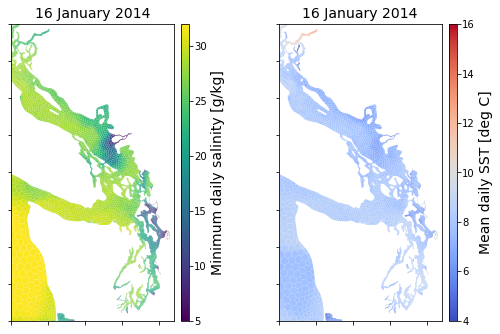

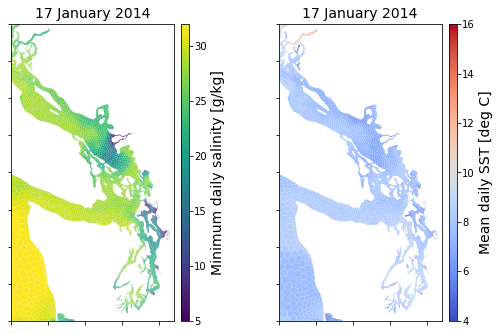

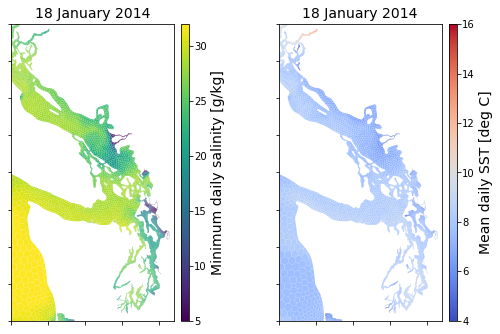

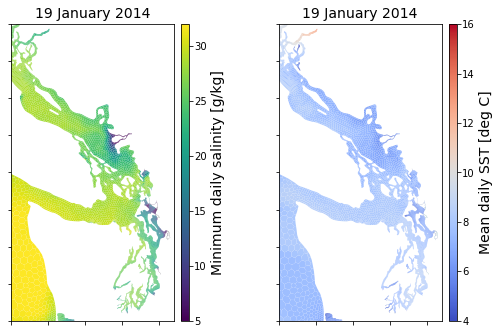

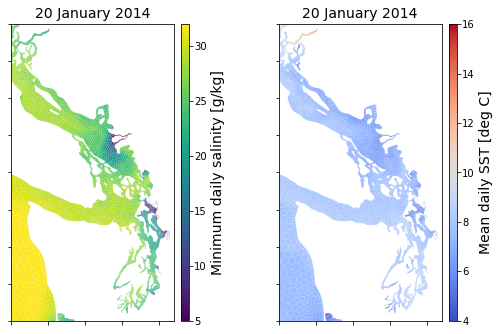

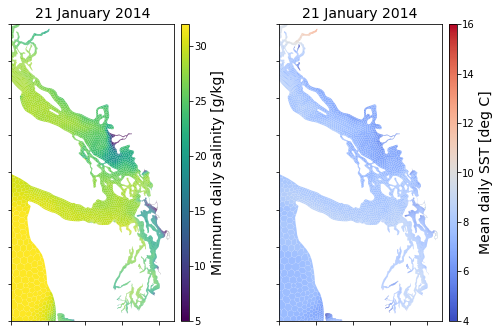

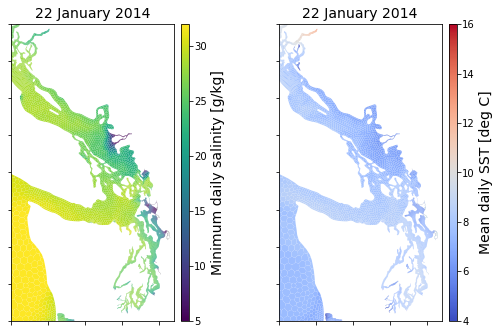

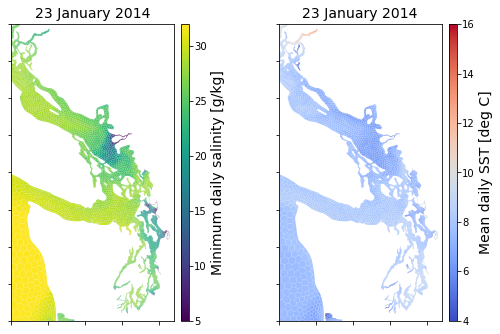

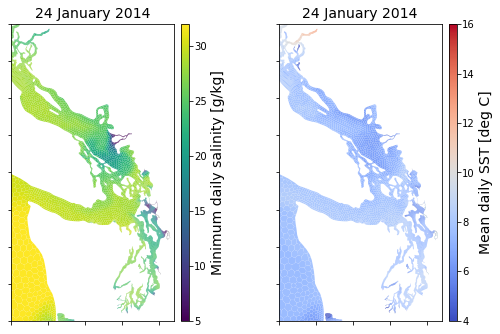

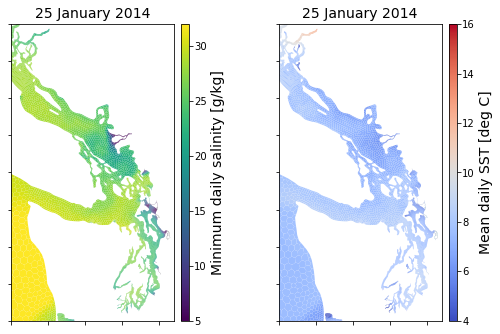

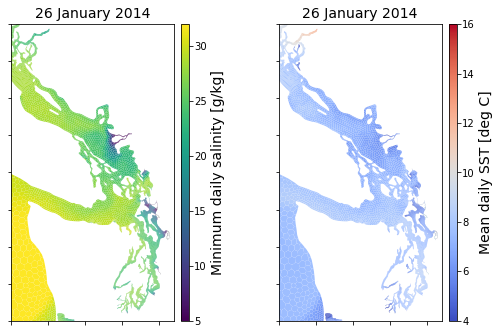

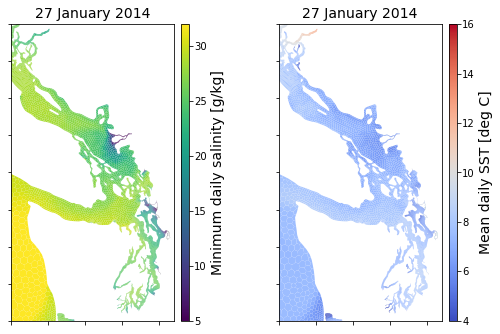

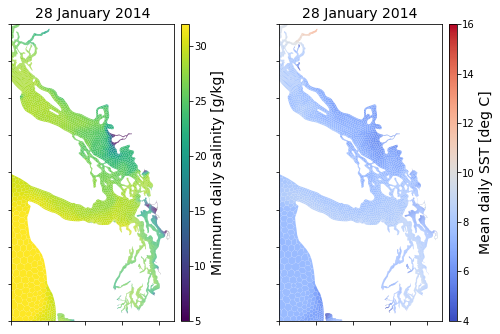

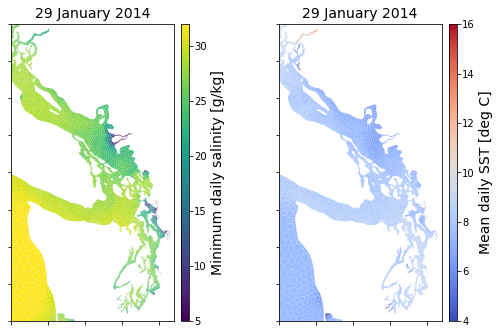

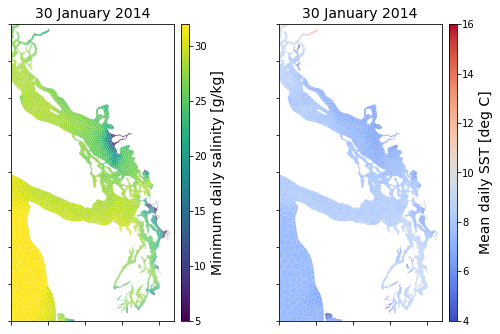

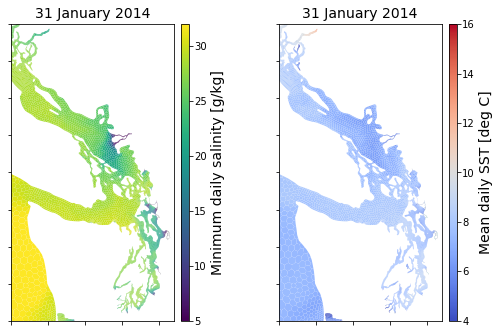

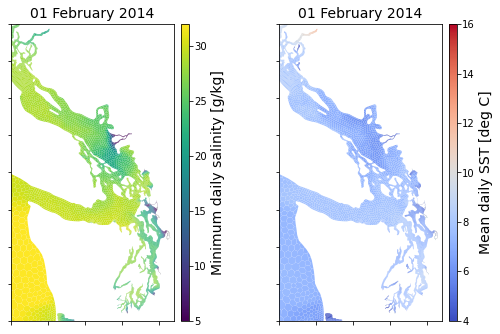

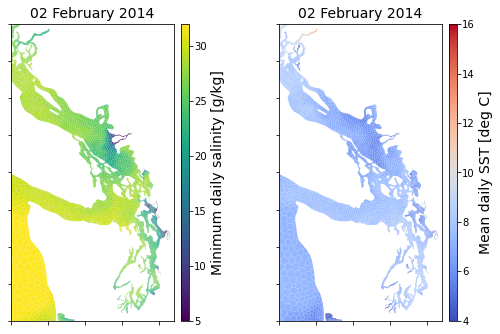

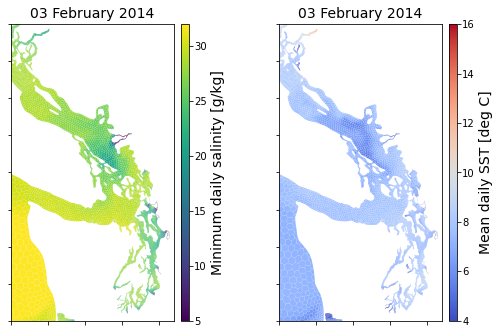

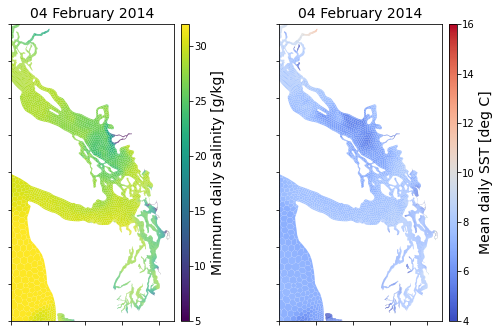

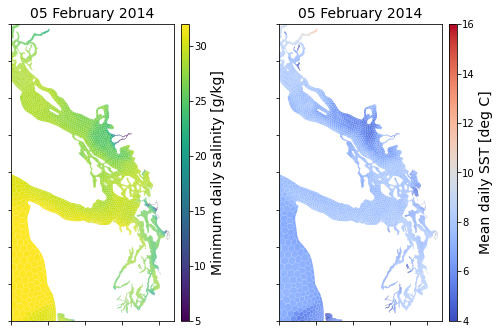

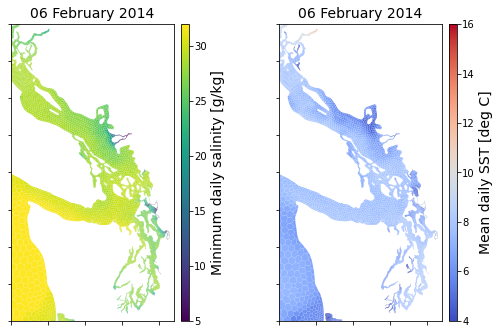

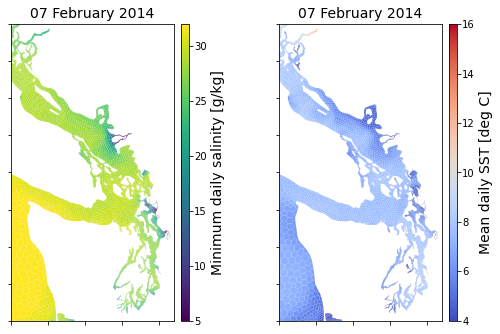

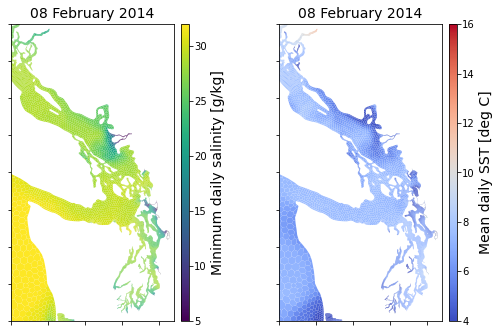

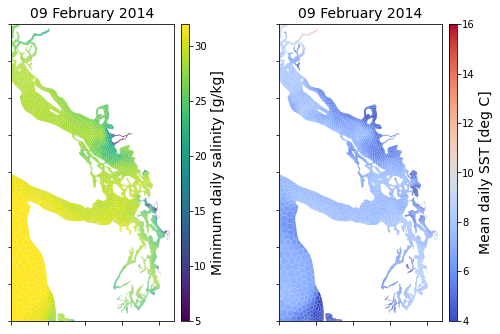

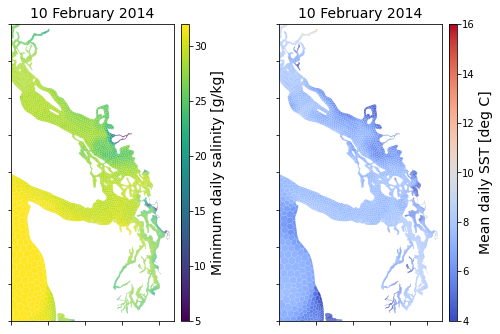

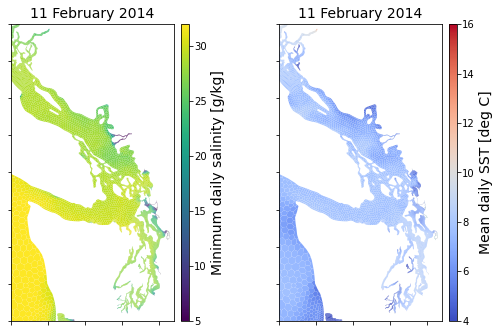

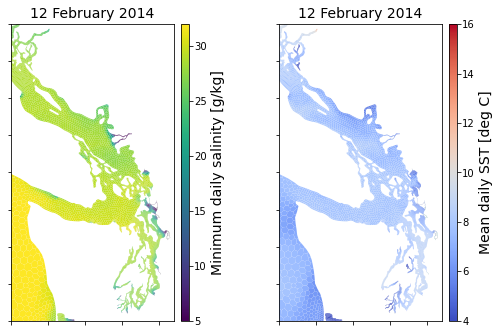

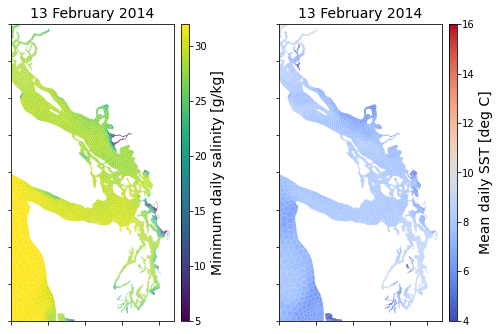

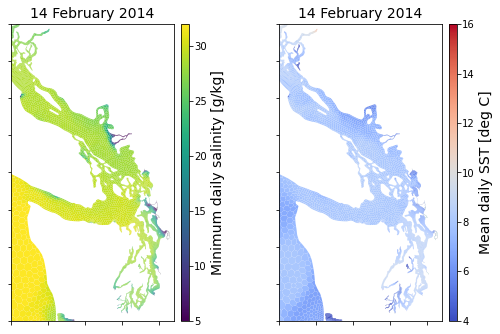

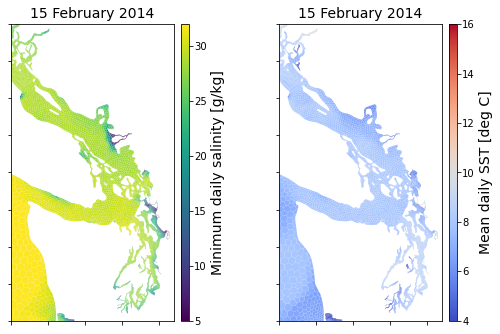

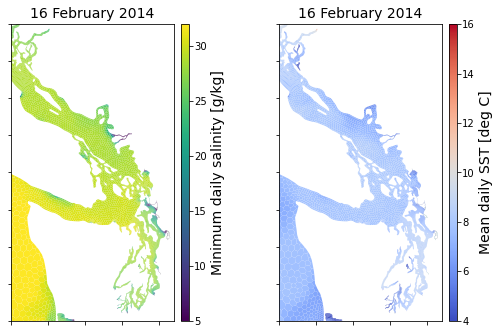

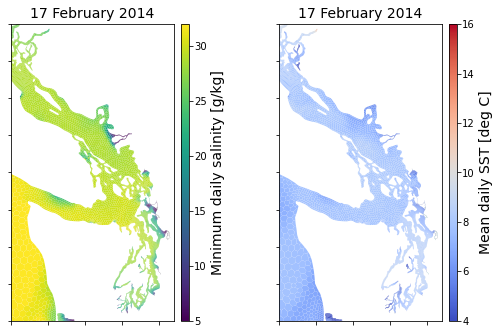

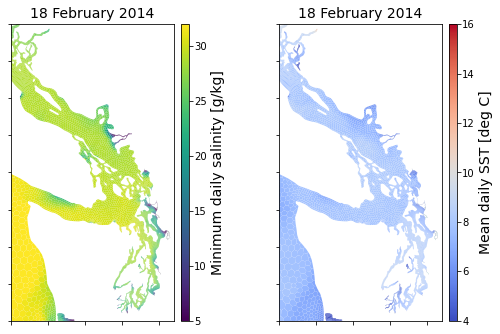

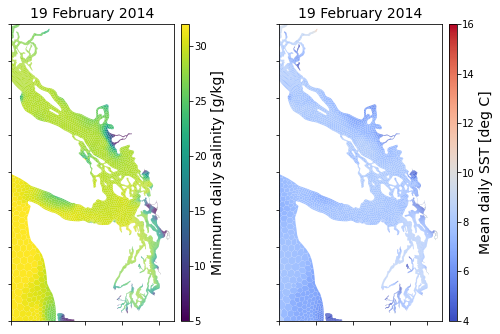

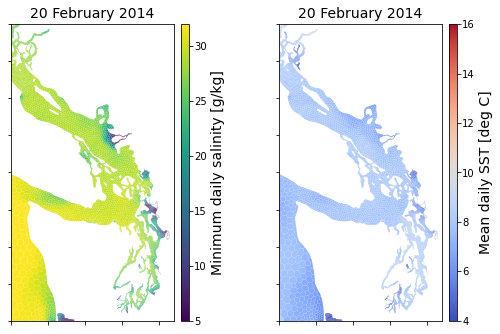

In [16]:
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
gdir = pathlib.Path(
    '/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/KingCounty-Rachael/graphics/SS_SalinityTemp/')
fs_t=14
fs_a=12
cax={}
for day in range(15,51):
    # Converting to date
    date = strt_date + timedelta(days=int(day))
    date_title = date.strftime("%d %B %Y")
    # Extract Salinity and Temp for day
    gdf_b['Salinity']= daily_tmin_zmin[day,:]
    gdf_b['Temp']= dailyT_tavg_rshp[day,:,0] # surface level = 0
    # Plot results
    fig, axs = plt.subplots(
        1,2, figsize = (8,6),
           gridspec_kw={
           'width_ratios': [1, 1],
           'height_ratios': [1],
       'wspace': 0.5,
       'hspace': 0})
    # create `cax` for the colorbar
    divider = make_axes_locatable(axs[0])
    cax[0] = divider.append_axes("right", size="5%", pad=0.1)
    gdf_b.plot('Salinity', ax=axs[0], cax=cax[0], legend=True,vmin=5, vmax=32)
    cax[0].set_ylabel(f'Minimum daily salinity [g/kg]',fontsize=14)
    axs[0].set(yticklabels='', xticklabels='')
    axs[0].set(ylim=(5.2e6,5.6e6),xlim=(3.5e5,5.7e5))
    axs[0].set_title(date_title, fontsize=fs_t)
    
    divider = make_axes_locatable(axs[1])
    cax[1] = divider.append_axes("right", size="5%", pad=0.1)
    gdf_b.plot('Temp', ax=axs[1], cax=cax[1], legend=True,vmin=4, vmax=16,
              cmap='coolwarm')
    cax[1].set_ylabel(f'Mean daily SST [deg C]',fontsize=14)
    axs[1].set(yticklabels='', xticklabels='')
    axs[1].set(ylim=(5.2e6,5.6e6),xlim=(3.5e5,5.7e5))
    axs[1].set_title(date_title, fontsize=fs_t)
    plt.savefig(gdir/f'SS_SalinityTemp_{day}.jpeg',dpi=150)